In [1]:
import glob
import os
import random
import torch
import torchvision
from PIL import Image
from tqdm import tqdm
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import xml.etree.ElementTree as ET
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import random_split, DataLoader
from torchvision.ops import box_iou
import numpy as np

In [2]:
def load_images_and_anns(im_dir, ann_dir, label2idx):
    r"""
    Method to get the xml files and for each file
    get all the objects and their ground truth detection
    information for the dataset
    :param im_dir: Path of the images
    :param ann_dir: Path of annotation xmlfiles
    :param label2idx: Class Name to index mapping for dataset
    :return:
    """
    im_infos = []
    for ann_file in tqdm(glob.glob(os.path.join(ann_dir, '*.xml'))):
        im_info = {}
        im_info['img_id'] = os.path.basename(ann_file).split('.xml')[0]
        im_info['filename'] = os.path.join(im_dir, '{}.png'.format(im_info['img_id']))
        ann_info = ET.parse(ann_file)
        root = ann_info.getroot()
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        im_info['width'] = width
        im_info['height'] = height
        detections = []
        
        for obj in ann_info.findall('object'):
            det = {}
            label = label2idx[obj.find('name').text]
            bbox_info = obj.find('bndbox')
            bbox = [
                int(float(bbox_info.find('xmin').text))-1,
                int(float(bbox_info.find('ymin').text))-1,
                int(float(bbox_info.find('xmax').text))-1,
                int(float(bbox_info.find('ymax').text))-1
            ]
            det['label'] = label
            det['bbox'] = bbox
            detections.append(det)
        im_info['detections'] = detections
        im_infos.append(im_info)
    print('Total {} images found'.format(len(im_infos)))
    return im_infos


In [3]:
class VOCDataset(Dataset):
    def __init__(self, split, im_dir, ann_dir):
        self.split = split
        self.im_dir = im_dir
        self.ann_dir = ann_dir
        classes = [
            'Rickshaw', 'Car', 'Motorcycle', 'Pedestrian', 'Leguna', 'Truck', 'Bus', 'CNG'
        ]
        classes = sorted(classes)
        classes = ['background'] + classes
        self.label2idx = {classes[idx]: idx for idx in range(len(classes))}
        self.idx2label = {idx: classes[idx] for idx in range(len(classes))}
        print(self.idx2label)
        self.images_info = load_images_and_anns(im_dir, ann_dir, self.label2idx)
    
    def __len__(self):
        return len(self.images_info)
    
    def __getitem__(self, index):
        im_info = self.images_info[index]
        im = Image.open(im_info['filename']).convert('RGB')
        to_flip = False
        if self.split == 'train' and random.random() < 0.5:
            to_flip = True
            im = im.transpose(Image.FLIP_LEFT_RIGHT)
        im_tensor = torchvision.transforms.ToTensor()(im)
        targets = {}
        targets['boxes'] = torch.as_tensor([detection['bbox'] for detection in im_info['detections']])
        targets['labels'] = torch.as_tensor([detection['label'] for detection in im_info['detections']])
        if to_flip:
            for idx, box in enumerate(targets['boxes']):
                x1, y1, x2, y2 = box
                w = x2-x1
                im_w = im_tensor.shape[-1]
                x1 = im_w - x1 - w
                x2 = x1 + w
                targets['boxes'][idx] = torch.as_tensor([x1, y1, x2, y2])
        return im_tensor, targets, im_info['filename']

In [4]:
dataset = VOCDataset(split='train', im_dir='/kaggle/input/road-dataset/Traffic/JPEGImages', ann_dir='/kaggle/input/road-dataset/Traffic/Annotations')

{0: 'background', 1: 'Bus', 2: 'CNG', 3: 'Car', 4: 'Leguna', 5: 'Motorcycle', 6: 'Pedestrian', 7: 'Rickshaw', 8: 'Truck'}


100%|██████████| 149/149 [00:01<00:00, 114.49it/s]

Total 149 images found


In [5]:
# Example of accessing a sample
im_tensor, targets, filename = dataset[0]
print(f"Filename: {filename}")
print(f"Bounding Boxes: {targets['boxes']}")
print(f"Labels: {targets['labels']}")

Filename: /kaggle/input/road-dataset/Traffic/JPEGImages/Screenshot (676).png
Bounding Boxes: tensor([[ 958,  606, 1042,  702],
        [ 811,  615,  879,  794],
        [1656,  567, 1768,  856],
        [1046,  577, 1186,  826],
        [1498,  567, 1632,  865],
        [ 310,  596,  456,  744],
        [  41,  446,  287,  771]])
Labels: tensor([4, 6, 6, 6, 6, 3, 1])


In [6]:
def split_dataset(dataset, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    train_size = int(len(dataset) * train_ratio)
    val_size = int(len(dataset) * val_ratio)
    test_size = len(dataset) - train_size - val_size
    return random_split(dataset, [train_size, val_size, test_size])
train_dataset, val_dataset, test_dataset = split_dataset(dataset)    

In [7]:
# Create the DataLoader
train_data_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_data_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_data_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [8]:
# Define the device (GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [9]:
# Load the pre-trained Faster R-CNN model with a ResNet50 backbone
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 198MB/s]  


In [10]:
# Replace the classifier to match the number of classes in your dataset
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = len(dataset.label2idx)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [11]:
# Move model to device
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [23]:
# Define the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=0.0001)

In [13]:
# Define the learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [28]:
# Function to calculate mAP for validation
def calculate_map(model, data_loader, device, iou_threshold=0.5):
    model.eval()
    total_ap = []
    
    with torch.no_grad():
        for images, targets, _ in data_loader:
            images = [image.to(device) for image in images]
            gt_boxes = [t['boxes'].to(device) for t in targets]
            gt_labels = [t['labels'].to(device) for t in targets]

            # Get predictions
            predictions = model(images)
            pred_boxes = [pred['boxes'] for pred in predictions]
            pred_scores = [pred['scores'] for pred in predictions]
            pred_labels = [pred['labels'] for pred in predictions]

            # Compute AP for each class
            for class_id in range(1, len(dataset.label2idx)):  # Skip background
                tp = 0  # True positives
                fp = 0  # False positives
                total_gt = 0
                
                for i in range(len(images)):
                    # Get ground-truth and predicted boxes for this class
                    gt_mask = gt_labels[i] == class_id
                    pred_mask = pred_labels[i] == class_id

                    gt_b = gt_boxes[i][gt_mask]
                    pred_b = pred_boxes[i][pred_mask]
                    pred_s = pred_scores[i][pred_mask]

                    total_gt += gt_b.shape[0]

                    if len(pred_b) == 0:
                        continue

                    # Sort predictions by confidence score
                    sorted_indices = pred_s.argsort(descending=True)
                    pred_b = pred_b[sorted_indices]

                    # Compute IoU
                    if len(gt_b) > 0:
                        iou_matrix = box_iou(pred_b, gt_b)
                        max_iou, _ = iou_matrix.max(dim=1)

                        # Count TP/FP
                        tp += (max_iou >= iou_threshold).sum().item()
                        fp += (max_iou < iou_threshold).sum().item()
                    else:
                        fp += len(pred_b)

                # Compute precision & recall
                if total_gt == 0:
                    continue
                
                precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                recall = tp / total_gt if total_gt > 0 else 0

                # Compute AP (Approximating with precision value for simplicity)
                total_ap.append(precision)

    # Compute mAP
    mean_ap = np.mean(total_ap) if len(total_ap) > 0 else 0
    return mean_ap

# Training loop with validation mAP
num_epochs = 30
train_losses = []
val_mAPs = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    
    # Training Phase
    for images, targets, _ in train_data_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass for loss calculation
        loss_dict = model(images, targets)
        
        # Total loss
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    # Record training loss
    train_losses.append(epoch_loss / len(train_data_loader))

    # Validation Phase - Compute mAP
    val_mAP = calculate_map(model, val_data_loader, device)
    val_mAPs.append(val_mAP)

    # Step the learning rate scheduler
    #lr_scheduler.step()

    # Print Training Loss and Validation mAP
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss/len(train_data_loader):.4f}, Validation mAP: {val_mAP:.4f}')

Epoch 1/30, Training Loss: 0.1258, Validation mAP: 0.6027
Epoch 2/30, Training Loss: 0.1251, Validation mAP: 0.6272
Epoch 3/30, Training Loss: 0.1157, Validation mAP: 0.6423
Epoch 4/30, Training Loss: 0.1133, Validation mAP: 0.6832
Epoch 5/30, Training Loss: 0.1131, Validation mAP: 0.6655
Epoch 6/30, Training Loss: 0.1092, Validation mAP: 0.6730
Epoch 7/30, Training Loss: 0.1091, Validation mAP: 0.6541
Epoch 8/30, Training Loss: 0.1070, Validation mAP: 0.6736
Epoch 9/30, Training Loss: 0.1019, Validation mAP: 0.6843
Epoch 10/30, Training Loss: 0.1006, Validation mAP: 0.7072
Epoch 11/30, Training Loss: 0.1017, Validation mAP: 0.7423
Epoch 12/30, Training Loss: 0.0960, Validation mAP: 0.6956
Epoch 13/30, Training Loss: 0.0939, Validation mAP: 0.6180
Epoch 14/30, Training Loss: 0.0977, Validation mAP: 0.6742
Epoch 15/30, Training Loss: 0.0942, Validation mAP: 0.6206
Epoch 16/30, Training Loss: 0.0919, Validation mAP: 0.6791
Epoch 17/30, Training Loss: 0.0860, Validation mAP: 0.7109
Epoch 

In [29]:
def evaluate_test_set(model, data_loader, device):
    model.eval()
    test_mAP = calculate_map(model, data_loader, device)
    print(f'Test mAP: {test_mAP:.4f}')
    return test_mAP

evaluate_test_set(model, test_data_loader, device)

Test mAP: 0.5317


0.5317018446174455

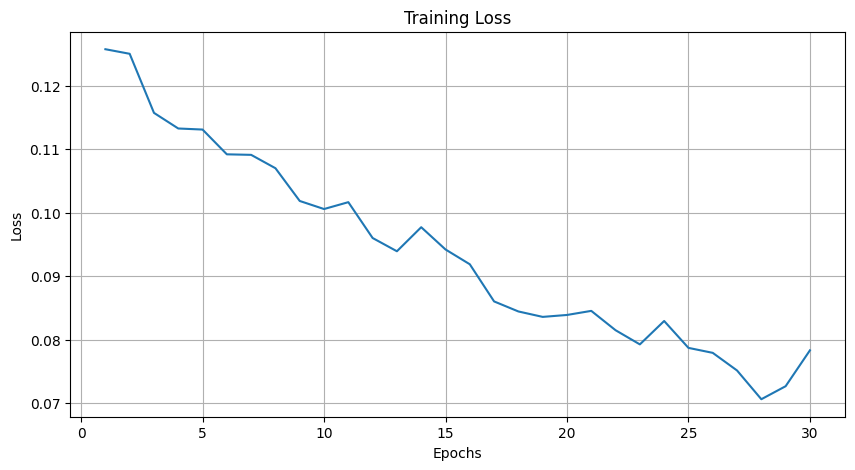

In [30]:
# Plotting Loss for the entire training
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

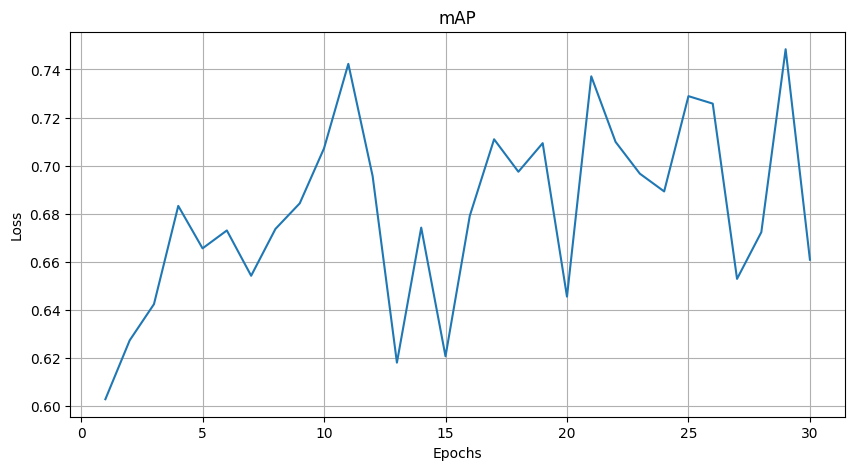

In [31]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs + 1), val_mAPs, label='mAPs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('mAP')
plt.grid(True)
plt.show()